In [396]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import string

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
import re
from collections import Counter

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.datasets import make_blobs

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
df = pd.read_json('../data/lyrics_cleaned.json')

In [3]:
df.head()

,artist,title,lyrics,character_count,word_count
0,Drake,Toosie Slide,"Black leather gloves, no sequins (Yeah, yeah, ...",2371,447
1,Roddy Ricch,The Box,Pullin' out the coupe at the lot Told 'em fuc...,2689,551
2,Dua Lipa,Don't Start Now,"If you don't wanna see me Did a full 180, cra...",1576,304
3,Doja Cat,Say So,"Day and night til morning, keeping me in the m...",2203,446
4,Post Malone,Circles,"Hey, hey, hey, hey Oh, oh, oh-oh Oh, oh, oh-...",1570,318


In [4]:
df.reset_index(drop=True,inplace=True)

In [5]:
df = df.drop(['character_count', 'word_count'], axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6252 entries, 0 to 6251
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  6252 non-null   object
 1   title   6252 non-null   object
 2   lyrics  6252 non-null   object
dtypes: object(3)
memory usage: 146.7+ KB


In [7]:
df.head()

,artist,title,lyrics
0,Drake,Toosie Slide,"Black leather gloves, no sequins (Yeah, yeah, ..."
1,Roddy Ricch,The Box,Pullin' out the coupe at the lot Told 'em fuc...
2,Dua Lipa,Don't Start Now,"If you don't wanna see me Did a full 180, cra..."
3,Doja Cat,Say So,"Day and night til morning, keeping me in the m..."
4,Post Malone,Circles,"Hey, hey, hey, hey Oh, oh, oh-oh Oh, oh, oh-..."


In [8]:
df.tail()

,artist,title,lyrics
6247,Lost Boyz,Lifestyles Of The Rich And Shameless,>Freaky Tahverses Mr. CheeksIntro:[Freaky Tah]...
6248,DJ Quik,Safe + Sound,"~Static~ ""Quik you're not a gangster we're not..."
6249,Ty Herndon,What Mattered Most,I thought I knew the girl so well If she was ...
6250,Madonna,Bedtime Story,Today Is the last day That I'm using words ...
6251,Livin' Joy,Dreamer,"Love, life and laughter Is all I beleive. My..."


In [9]:
punctuations = string.punctuation
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()


def remove_bracketed(song):
    text = re.sub("\[.*?\]", '', song)
    text = re.sub("\(.*?\)", '', text)
    text = re.sub("\{.*?\}", '', text)
    
    return text


def spacy_tokenizer(text, use_stopwords=True, custom_stopwords=set()):
    text = remove_bracketed(text)
    mytokens = parser(text)
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else "-PRON-" for word in mytokens ]
#     mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    if use_stopwords:
        mytokens = [word for word in mytokens if word not in (stop_words | custom_stopwords) and word not in punctuations ]
    else:
        mytokens = [word for word in mytokens if word not in punctuations ]

    return mytokens


def tokenize_column(dataframe, column_name, use_stopwords=True, custom_stopwords=set()):
    df_ = dataframe.reset_index(drop=True)
    token_list = []
    for song in df_[column_name]:
        token_list.append(spacy_tokenizer(song, use_stopwords, custom_stopwords))
    
    return token_list



In [10]:
lyric_stopwords = set(['hey', 'baby', 'babe', 'woo', 'ha', 'like', 'oh', 'ooh', 'woah', 'yeah'])
df['lyrics_tokens'] = tokenize_column(df, 'lyrics', use_stopwords=True, custom_stopwords=lyric_stopwords)

In [11]:
df.head(10)

,artist,title,lyrics,lyrics_tokens
0,Drake,Toosie Slide,"Black leather gloves, no sequins (Yeah, yeah, ...","[black, leather, glove, sequin, buckles, jacke..."
1,Roddy Ricch,The Box,Pullin' out the coupe at the lot Told 'em fuc...,"[pullin, coupe, lot, told, -PRON-, fuck, 12, f..."
2,Dua Lipa,Don't Start Now,"If you don't wanna see me Did a full 180, cra...","[wanna, 180, crazy, thinking, way, heartbreak,..."
3,Doja Cat,Say So,"Day and night til morning, keeping me in the m...","[day, night, til, morning, moment, -PRON-, let..."
4,Post Malone,Circles,"Hey, hey, hey, hey Oh, oh, oh-oh Oh, oh, oh-...","[turn, til, upside, -PRON-, bad, guy, proud, t..."
5,Justin Bieber Featuring Quavo,Intentions,"Picture perfect, you don't need no filter Gor...","[picture, perfect, need, filter, gorgeous, -PR..."
6,DaBaby Featuring Roddy Ricch,ROCKSTAR,"Woo, woo I pull up like How you pull up, Bab...","[pull, pull, pull, pull, pull, let, -PRON-, br..."
7,Future Featuring Drake,Life Is Good,Workin' on the weekend like usual Way off in ...,"[workin, weekend, usual, way, deep, end, usual..."
8,Billie Eilish,everything i wanted,I had a dream I got everything I wanted Not ...,"[dream, want, -PRON-, think, -PRON-, bein, hon..."
9,Camila Cabello Featuring DaBaby,My Oh My,"Ha, ha, ha, ha They say he likes a good time ...","[good, time, come, alive, midnight, mama, trus..."


In [12]:
idx = np.random.randint(0, 6252)

In [13]:
print(df.iloc[idx, 0], ' - ', df.iloc[idx, 1],'\n\n-----\n\n', df.iloc[idx, 2], '\n\n-----\n\n', df.iloc[idx, 3])

Dixie Chicks  -  Travelin' Soldier 

-----

 Two days past eighteen  He was waiting for the bus in his army greens  Sat down in a booth in a cafe there   Gave his order to a girl with a bow in her hair  He's a little shy so she give him a smile  So he said would you mind sittin' down for a while   And talking to me, I'm feeling a little low   She said I'm off in an hour and I know where we can go   So they went down and they sat on the pier   He said I bet you got a boyfriend but I don't care   I got no one to send a letter to   Would you mind if I sent one back here to you   I cried   Never gonna hold the hand of another guy   Too young for him they told her   Waitin' for the love of a travelin' soldier   Our love will never end   Waitin' for the soldier to come back again   Never more to be alone when the letter says   A soldier's coming home     So the letters came from an army camp   In California then Vietnam   And he told her of his heart   It might be love and all of the things 

In [14]:
barbra = df[df['artist'] == 'Duck Sauce']['lyrics'][2191]

In [15]:
barbra

'Barbra Streisand  Woowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoow  Oowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowo   Owoowoowoowoowoo  Barbra Streisand    Woowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoow  Oowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowo  Owoowoowoowoowoo    Barbra Streisand    Woowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoow  Oowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowo  Owoowoowoowoowoo    Barbra Streisand    Woowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoow  Oowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowo  Owoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoo  Woowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoow  Oowoowoowoowoowoowoowoowoowoowoowoowoo    Barbra Streisand    Woowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoow  Oowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowo  Owoowoowoowoowoo    Barbra Streisand    Wowowo wowowo wowowowoowoo  Woowoowoowoowoowoowoowoowoowoowoo wowowo wowowo 

In [16]:
set((re.sub("woo*", '', barbra.lower())).split())

{'(merci',
 'barbra',
 'cettes',
 'hugo',
 'o',
 'oo',
 'paroles)',
 'pour',
 'streisand',
 'w',
 'à'}

In [17]:
df.head()

,artist,title,lyrics,lyrics_tokens
0,Drake,Toosie Slide,"Black leather gloves, no sequins (Yeah, yeah, ...","[black, leather, glove, sequin, buckles, jacke..."
1,Roddy Ricch,The Box,Pullin' out the coupe at the lot Told 'em fuc...,"[pullin, coupe, lot, told, -PRON-, fuck, 12, f..."
2,Dua Lipa,Don't Start Now,"If you don't wanna see me Did a full 180, cra...","[wanna, 180, crazy, thinking, way, heartbreak,..."
3,Doja Cat,Say So,"Day and night til morning, keeping me in the m...","[day, night, til, morning, moment, -PRON-, let..."
4,Post Malone,Circles,"Hey, hey, hey, hey Oh, oh, oh-oh Oh, oh, oh-...","[turn, til, upside, -PRON-, bad, guy, proud, t..."


In [18]:
len(df.columns)

4

In [19]:
df['word_count'] = 0
df['unique_word_count'] = 0
for idx, row in enumerate(df['lyrics']):
    df.iloc[idx, len(df.columns)-2] = len(row.split())
    df.iloc[idx, len(df.columns)-1] = len(set(row.split()))

    
df['token_count'] = 0
df['unique_token_count'] = 0
for idx, row in enumerate(df['lyrics_tokens']):
    df.iloc[idx, len(df.columns)-2] = len(row)
    df.iloc[idx, len(df.columns)-1] = len(set(row))

In [20]:
df.head()

,artist,title,lyrics,lyrics_tokens,word_count,unique_word_count,token_count,unique_token_count
0,Drake,Toosie Slide,"Black leather gloves, no sequins (Yeah, yeah, ...","[black, leather, glove, sequin, buckles, jacke...",447,166,206,71
1,Roddy Ricch,The Box,Pullin' out the coupe at the lot Told 'em fuc...,"[pullin, coupe, lot, told, -PRON-, fuck, 12, f...",551,209,249,124
2,Dua Lipa,Don't Start Now,"If you don't wanna see me Did a full 180, cra...","[wanna, 180, crazy, thinking, way, heartbreak,...",304,100,87,31
3,Doja Cat,Say So,"Day and night til morning, keeping me in the m...","[day, night, til, morning, moment, -PRON-, let...",446,164,135,74
4,Post Malone,Circles,"Hey, hey, hey, hey Oh, oh, oh-oh Oh, oh, oh-...","[turn, til, upside, -PRON-, bad, guy, proud, t...",318,118,134,38


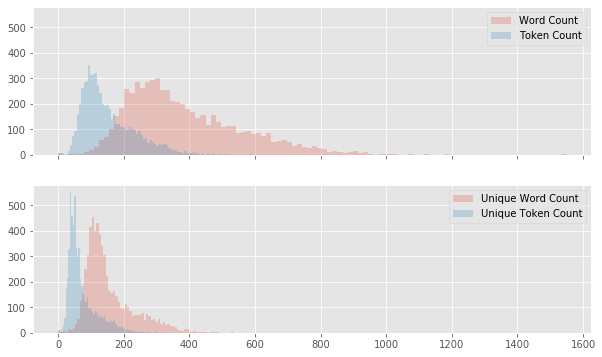

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)
ax[0].hist(df['word_count'], bins=100, label='Word Count', alpha=.25)
ax[0].hist(df['token_count'], bins=100, label='Token Count', alpha=.25)
ax[1].hist(df['unique_word_count'], bins=100, label='Unique Word Count', alpha=.25)
ax[1].hist(df['unique_token_count'], bins=100, label='Unique Token Count', alpha=.25)
ax[0].legend(loc='best')
ax[1].legend(loc='best');

''

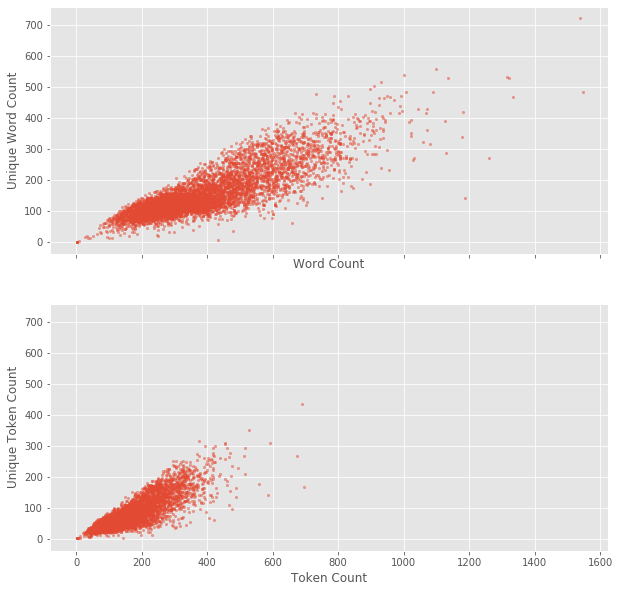

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True, sharey=True)
ax[0].scatter(df['word_count'], df['unique_word_count'], alpha=0.5, s=6)
ax[1].scatter(df['token_count'], df['unique_token_count'], alpha=0.5, s=6)
ax[0].set_xlabel('Word Count')
ax[1].set_xlabel('Token Count')
ax[0].set_ylabel('Unique Word Count')
ax[1].set_ylabel('Unique Token Count')
;

In [23]:
df[(df['word_count'] > 1100) & (df['unique_word_count'] < 200)]

,artist,title,lyrics,lyrics_tokens,word_count,unique_word_count,token_count,unique_token_count
6147,Nicki French,Total Eclipse Of The Heart,"Turnaround, Every now and then I get a little ...","[turnaround, little, bite, lonely, -PRON-, com...",1186,143,420,60


In [24]:
idx = df[(df['word_count'] > 1100) & (df['unique_word_count'] < 200)].index[0]
wc = df.iloc[idx,:]['word_count']
unique = df.iloc[idx,:]['unique_word_count']
print(unique / wc)

0.1205733558178752


In [25]:
df.iloc[idx,:]['lyrics']

"Turnaround, Every now and then I get a little bit lonely and you're never coming round  Turnaround, Every now and then I get a little bit tired of listening to the sound of my tears  Turnaround, Every now and then I get a little bit nervous that the best of all the years have gone by   Turnaround, Every now and then I get a little bit terrified and then I see the look in your eyes  Turnaround bright eyes, Every now and then I fall apart  Turnaround bright eyes, Every now and then I fall apart    Turnaround, Every now and then I get a little bit restless and I dream of something wild  Turnaround, Every now and then I get a little bit helpless and I'm lying like a child in your arms  Turnaround, Every now and then I get a little bit angry and I know I've got to get out and cry  Turnaround, Every now and then I get a little bit terrified but then I see the look in your eyes  Turnaround bright eyes, Every now and then I fall apart  Turnaround bright eyes, Every now and then I fall apart  

In [26]:
df[(df['word_count'] < 750) & (df['unique_word_count'] > 450)]

,artist,title,lyrics,lyrics_tokens,word_count,unique_word_count,token_count,unique_token_count
6127,Kool G Rap,Fast Life,"(feat. Nas) The time has come, we gotta expan...","[time, come, expand, operation, distribution, ...",732,477,376,316


In [27]:
idx = df[(df['word_count'] < 750) & (df['unique_word_count'] > 450)].index[0]
wc = df.iloc[idx,:]['word_count']
unique = df.iloc[idx,:]['unique_word_count']
print(unique / wc)

0.6516393442622951


In [28]:
df.iloc[idx,:]['lyrics']

'(feat. Nas)  The time has come, we gotta expand, the whole operation   Distribution, New York, to Chicago, L.A.  We gotta set our own market, and enforce it  [Verse One: Kool G Rap]    Champagne wishes of caviar dreams ?a penis didn\'t cream?  With sales of fish scales from triple beams I gleam  Livin the live of rowdy packin fifty cali\'s  Rockin lizard Bally\'s while we do our drug deal in a dark alley  Up in casinos just me and my dino primo  Pushin beam-o\'s then parlay in Reno with two fly latinos  Nas, he runs the whole staff, we count mad for seen bad  We\'ve seen a half a milli dashin out there on the Queens half  Three major players gettin papers by the layers  And those that portray us on the block get rocked like Domateus  Fakers get used to shootin targets, soon as the dark hits  Front on the drug market, bodies get rolled up in a carpet  Those that cheat us try to beat us we got hookers with heaters  that\'ll stray pop and put more shells in your top than Adidas  Da leade

In [29]:
df[df['title'] == 'Rap God']

,artist,title,lyrics,lyrics_tokens,word_count,unique_word_count,token_count,unique_token_count
1520,Eminem,Rap God,"Look, I was gonna go easy on you not to hurt y...","[look, easy, hurt, feeling, -PRON-, chance, wr...",1539,722,689,435


In [30]:
wc = df[df['title'] == 'Rap God']['word_count'][1520]
unique = df[df['title'] == 'Rap God']['unique_word_count'][1520]
print(unique / wc)

0.4691358024691358


In [31]:
df[(df['token_count'] > 600) & (df['unique_token_count'] >400)]

,artist,title,lyrics,lyrics_tokens,word_count,unique_word_count,token_count,unique_token_count
1520,Eminem,Rap God,"Look, I was gonna go easy on you not to hurt y...","[look, easy, hurt, feeling, -PRON-, chance, wr...",1539,722,689,435


In [32]:
def tf(term, document_tokens):
    term_occ = document_tokens.count(term)
    total_tokens = len(document_tokens)
    return term_occ / total_tokens



def get_tf(document_tokens):
    term_freqs = {}
    for token in document_tokens:
        if token not in term_freqs:
            term_freqs[token] = tf(token, document_tokens)
    return term_freqs
    

def get_idf_dict(corpus):
    occ_dict = {}
    for doc in corpus:
        for token in doc:
            if token not in occ_dict:
                occ_dict[token] = 1
            else:
                occ_dict[token] += 1
    return occ_dict

def get_doc_freq_dict(corpus):
    doc_occs = Counter([word for row in corpus for word in set(row)])
    doc_freq = {k: (v / float(len(corpus))) for k, v in doc_occs.items()}
    return doc_freq


def vectorize_tokens(pandas_series):
    docs = pandas_series.to_numpy()
    doc_freq = get_doc_freq_dict(working_df['lyrics_tokens'])
    vocabulary = [k for k,v in doc_freq.items()]
    vectors = np.zeros((len(docs),len(vocabulary)))

    for i in range(len(docs)):
        for j in range(len(vocabulary)):
            term     = vocabulary[j]
            term_tf  = tf(term, docs[i])   # 0.0 if term not found in doc
            term_idf = np.log(1 + (1 / doc_freq[term])) # smooth formula
            vectors[i,j] = term_tf * term_idf
    return vectors, vocabulary



In [337]:
top_artist = df.groupby(by='artist').count().sort_values(by='title',ascending=False).loc[:,'title']
top_artist[:50]

artist
Taylor Swift           58
Kenny Chesney          42
Tim McGraw             39
Keith Urban            37
Drake                  33
Rascal Flatts          32
Brad Paisley           32
George Strait          30
Toby Keith             30
Jason Aldean           29
Carrie Underwood       28
Blake Shelton          27
Eminem                 26
Rihanna                25
Luke Bryan             25
Kelly Clarkson         23
P!nk                   23
Dierks Bentley         23
Beyonce                23
Britney Spears         22
Alan Jackson           21
Usher                  20
Madonna                20
Maroon 5               19
Chris Brown            19
Brooks & Dunn          18
R. Kelly               18
Katy Perry             18
J. Cole                17
Nickelback             17
Montgomery Gentry      17
Eric Church            17
Miranda Lambert        17
Justin Timberlake      17
Kendrick Lamar         16
Billy Currington       16
Dixie Chicks           16
Lady Antebellum        16
Jake 

In [34]:
artist_list = list(top_artist[:5].index)
working_df = df[df['artist'].isin(artist_list)]

song_is_artist = pd.get_dummies(working_df['artist'], prefix='is')

In [35]:
song_is_artist.head()

,is_Drake,is_Keith Urban,is_Kenny Chesney,is_Taylor Swift,is_Tim McGraw
0,1,0,0,0,0
65,0,0,1,0,0
75,0,1,0,0,0
149,0,0,0,1,0
150,0,0,0,1,0


In [36]:
arr, vocab = vectorize_tokens(working_df['lyrics_tokens'])

model_df = pd.DataFrame(arr, columns=vocab)

In [37]:
def run_model(X, y, model_obj):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=.20)
    model = model_obj
    
    model.fit(X_train, y_train)

    return model.score(X_test, y_test)


def get_all_scores(df, dummy_targets_df, model_obj):
    target_scores = {}
    X = df.to_numpy()
    vocab_to_remove = set()
    for idx, target in enumerate(dummy_targets_df.columns):
        y = dummy_targets_df.iloc[:,idx].to_numpy()
        score = run_model(X, y, model_obj)
        target_scores[target] = {'score': round(score, 3), 'imbalance': round((sum(y) / len(y)), 3)}
    
    return target_scores

In [38]:
def get_vocab_to_add(trained_model, col_names, add_perc=0.2):
    num_to_remove = int(len(col_names) * add_perc)
    feat_scores = pd.Series(rfc.feature_importances_,
                               index=col_names)
    top_feats = feat_scores.sort_values()[-num_to_remove:]
    return top_feats

In [198]:
# get_all_scores(model_df, song_is_artist, GaussianNB())

In [40]:
is_artist = 'is_Taylor Swift'

arr, vocab_cols = vectorize_tokens(working_df['lyrics_tokens'])
model_df = pd.DataFrame(arr, columns=vocab)

X = arr
y = song_is_artist.iloc[:,song_is_artist.columns.get_loc(is_artist)]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=.20)

In [41]:
rfc = RandomForestClassifier(n_estimators=500,
                             max_features='auto',
                             oob_score=True).fit(X_train, y_train)
rfc.score(X_test, y_test)

In [42]:
gbcl = GradientBoostingClassifier(learning_rate=.01, 
                                  n_estimators=100, 
                                  criterion='mae').fit(X_train, y_train)
gbcl.score(X_test, y_test)

In [43]:
gnb = GaussianNB().fit(X_train, y_train)
gnb.score(X_test, y_test)

0.7619047619047619

In [45]:
# model = GradientBoostingClassifier()
# learning_rate_param = [.01, .001]
# n_estimators_param = np.arange(100,3100,1000)
# parameters = {'n_estimators' : n_estimators_param,
#              'learning_rate' : learning_rate_param}
# clf = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
# clf.fit(X_train,y_train)
# print('Accuracy score: {:.3}'.format(clf.score(X_test, y_test)))

In [46]:
# feat_scores = pd.Series(rfc.feature_importances_,
#                            index=vocab_cols)
# feat_scores = feat_scores.sort_values()[-50:]

# ax = feat_scores.plot(kind='barh', 
#                       figsize=(10,8),
#                       color='b')
# ax.set_title('Average Gini Importance')
# ax.set_xlabel('Average contribution to information gain');

# get_vocab_to_add(rfc, vocab_cols, add_perc=0.01)

In [ ]:
lyric_stopwords = set(['hey', 'baby', 'babe', 'woo', 'ha', 'like', 'oh', 'ooh', 'woah', 'yeah'])
all_stop_words = lyric_stopwords.union(STOP_WORDS)

In [354]:
artist_list = list(top_artist[:10].index)
working_df = df[df['artist'].isin(artist_list)]

song_is_artist = pd.get_dummies(working_df['artist'], prefix='is')

artist_list

['Taylor Swift',
 'Kenny Chesney',
 'Tim McGraw',
 'Keith Urban',
 'Drake',
 'Rascal Flatts',
 'Brad Paisley',
 'George Strait',
 'Toby Keith',
 'Jason Aldean']

In [359]:
# aggr_feat_imp_dict = {}
artist='Kenny Chesney'
# for artist in artist_list:
is_artist = 'is_{}'.format(artist)
y = song_is_artist.iloc[:,song_is_artist.columns.get_loc(is_artist)]

X_train, X_test, y_train, y_test = train_test_split(working_df['lyrics'], 
                                                    y, 
                                                    test_size=.40)

vectorizer = TfidfVectorizer(stop_words=all_stop_words,
                             max_features=5000
                            )
vectorizer.fit(X_train)
X_train_vec = vectorizer.transform(X_train)
features = vectorizer.get_feature_names()

imbrf = BalancedRandomForestClassifier(n_estimators=5000,
                                       max_features='auto', 
                                       sampling_strategy=0.5
                                      ).fit(X_train_vec, y_train)

X_test_vec = vectorizer.transform(X_test)

y_pred = imbrf.predict(X_test_vec)

#     for score, term in zip(imbrf.feature_importances_, features):
#         if term not in aggr_feat_imp_dict:
#             aggr_feat_imp_dict[term] = score
#         else:
#             aggr_feat_imp_dict[term] += score

/home/sean/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [345]:
aggr_feat_imp_dict

{'000': 1.1061642896959686e-05,
 '02': 0.0,
 '03': 0.0,
 '07': 0.0,
 '10': 4.140421818634197e-05,
 '100': 0.0,
 '11': 0.0,
 '13': 0.0,
 '14': 0.0,
 '14th': 0.0,
 '15': 0.00010008270718975308,
 '16': 5.206495833146352e-06,
 '17': 3.921506097857948e-05,
 '18': 0.0,
 '1991': 0.0,
 '1994': 0.0,
 '1da': 0.0,
 '1x': 0.0,
 '20': 0.00013850097698288032,
 '2010': 0.0,
 '2017': 0.0,
 '22': 0.0,
 '24': 0.0,
 '29': 0.0,
 '2x': 0.00013523396608522209,
 '30': 0.0001307389838972672,
 '32': 0.0,
 '40': 0.007279172831772455,
 '44': 0.0,
 '45': 0.00016657978248470085,
 '48': 0.0,
 '4am': 0.0,
 '50': 5.406576640421602e-06,
 '55': 0.0,
 '58': 0.0,
 '672': 0.0,
 '68': 0.0,
 '69': 2.3223158192223106e-05,
 '7th': 0.0,
 '800': 0.0,
 '81': 0.0,
 '96': 0.0,
 '97': 0.0,
 '9th': 0.0,
 'aaw': 0.0,
 'ab': 0.0,
 'abbott': 0.0,
 'abercrombie': 0.0,
 'abigail': 0.0,
 'abilene': 0.0,
 'able': 2.5346951747427875e-05,
 'ac': 0.0,
 'accept': 0.0,
 'acceptance': 0.0,
 'accomplishments': 0.0,
 'account': 0.0,
 'accustomed':

In [346]:
max(aggr_feat_imp_dict.values())

0.11629619424405695

In [347]:
important_feats_dict = {}
not_important_feats_dict = {}
for k, v in aggr_feat_imp_dict.items():
    if v > 0.01:
        important_feats_dict[k] = v
    else:
        not_important_feats_dict[k] = v

In [348]:
not_important_feats_dict

{'000': 1.1061642896959686e-05,
 '02': 0.0,
 '03': 0.0,
 '07': 0.0,
 '10': 4.140421818634197e-05,
 '100': 0.0,
 '11': 0.0,
 '13': 0.0,
 '14': 0.0,
 '14th': 0.0,
 '15': 0.00010008270718975308,
 '16': 5.206495833146352e-06,
 '17': 3.921506097857948e-05,
 '18': 0.0,
 '1991': 0.0,
 '1994': 0.0,
 '1da': 0.0,
 '1x': 0.0,
 '20': 0.00013850097698288032,
 '2010': 0.0,
 '2017': 0.0,
 '22': 0.0,
 '24': 0.0,
 '29': 0.0,
 '2x': 0.00013523396608522209,
 '30': 0.0001307389838972672,
 '32': 0.0,
 '40': 0.007279172831772455,
 '44': 0.0,
 '45': 0.00016657978248470085,
 '48': 0.0,
 '4am': 0.0,
 '50': 5.406576640421602e-06,
 '55': 0.0,
 '58': 0.0,
 '672': 0.0,
 '68': 0.0,
 '69': 2.3223158192223106e-05,
 '7th': 0.0,
 '800': 0.0,
 '81': 0.0,
 '96': 0.0,
 '97': 0.0,
 '9th': 0.0,
 'aaw': 0.0,
 'ab': 0.0,
 'abbott': 0.0,
 'abercrombie': 0.0,
 'abigail': 0.0,
 'abilene': 0.0,
 'able': 2.5346951747427875e-05,
 'ac': 0.0,
 'accept': 0.0,
 'acceptance': 0.0,
 'accomplishments': 0.0,
 'account': 0.0,
 'accustomed':

In [308]:
# feat_scores = pd.Series(imbrf.feature_importances_,
#                            index=features)
# feat_scores = feat_scores.sort_values()[:50]

# ax = feat_scores.plot(kind='barh', 
#                       figsize=(10,8),
#                       color='b')
# ax.set_title('Average Gini Importance')
# ax.set_xlabel('Average contribution to information gain');

In [360]:
print('Total songs: \t', len(working_df), 
      '\nTotal target: \t', sum(y), 
      '\nPercentage is target: \t', round((sum(y) / len(working_df)), 3), 
      '\nPercentage is not target: \t', round(((len(y) - sum(y)) / len(working_df)), 3))

Total songs: 	 362 
Total target: 	 42 
Percentage is target: 	 0.116 
Percentage is not target: 	 0.884


Precision: nan 
Recal: 0.0 
Accuracy: 0.903


/home/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


Text(0.5, 1, 'is_Kenny Chesney')

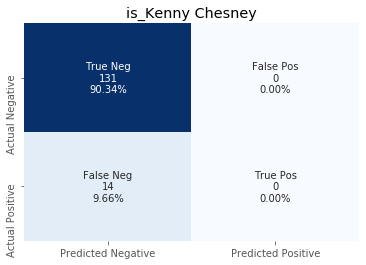

In [361]:
plot_conf_matrix(y_test, y_pred)
plt.title(is_artist)

In [218]:
def plot_conf_matrix(actuals, predictions):
    cf_matrix = confusion_matrix(actuals, predictions)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cf_matrix, 
                annot=labels, 
                fmt='', 
                cmap='Blues', 
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['Actual Negative', 'Actual Positive'], cbar=False)
    
    tn, fp, fn, tp = cf_matrix.flatten()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tn + fp + fn + tp)
    print(f"Precision: {round(precision, 3)} \nRecal: {round(recall, 3)} \nAccuracy: {round(accuracy, 3)}")

In [353]:
more_stopwords = all_stop_words.union(set(not_important_feats_dict.keys()))

In [393]:
even_more_stopwords = more_stopwords.union(set(['ambidex', 
                                               '000', 
                                               'aw', 
                                               'aaw', 
                                               '18', 
                                               '55', 
                                                'got', 
                                                'll', 
                                                'don', 
                                                've', 
                                                'gonna', 
                                                'ain', 
                                                'em', 
                                                'ayy', 
                                                'chorus', 
                                                'know']))

In [398]:
vectorizer = TfidfVectorizer(stop_words=even_more_stopwords)
X = vectorizer.fit_transform(working_df['lyrics'])
features = vectorizer.get_feature_names()
kmeans = KMeans(n_clusters=17)
kmeans.fit(X)

top_centroids = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
print("\n3) top features (words) for each cluster:")
for num, centroid in enumerate(top_centroids):
    print("%d: %s" % (num, ", ".join(features[i] for i in centroid)))


3) top features (words) for each cluster:
0: best, day, right, away, stay, life, today, free, cause, sun
1: little, let, pretty, good, wanna, live, love, girl, stay, days
2: time, night, red, sweet, fall, good, went, right, think, wish
3: need, find, gotta, way, blue, want, believe, wish, time, drive
4: shit, niggas, fuck, nigga, gotta, tryna, things, money, gon, want
5: forever, knew, eyes, somebody, night, love, feel, way, let, saw
6: god, live, lost, rain, true, couldn, love, today, long, crazy
7: old, friend, song, cause, time, perfect, feel, long, years, best
8: love, tonight, eyes, close, want, cause, alright, way, kiss, let
9: come, words, summer, lights, good, love, home, time, dream, feel
10: leave, want, love, tell, cause, mean, long, night, stand, need
11: said, good, man, big, bout, looking, bar, time, night, way
12: way, look, red, lot, getting, started, party, feels, time, thing
13: better, waiting, living, find, sun, new, love, come, hand, cause
14: think, people, cause

In [401]:
vectorizer = TfidfVectorizer(stop_words=even_more_stopwords)
X = vectorizer.fit_transform(working_df['lyrics'])
features = vectorizer.get_feature_names()

silhouette_scores = {}
for n_clusters in range(2, 1000):
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores[n_clusters] = silhouette_avg
    if n_clusters % 10 == 0:
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)


For n_clusters = 10 The average silhouette_score is : 0.020158305804064972
For n_clusters = 20 The average silhouette_score is : 0.024873095250325352
For n_clusters = 30 The average silhouette_score is : 0.028112001962398395
For n_clusters = 40 The average silhouette_score is : 0.03051081323082761
For n_clusters = 50 The average silhouette_score is : 0.034549631637670254
For n_clusters = 60 The average silhouette_score is : 0.038651208024117284
For n_clusters = 70 The average silhouette_score is : 0.0419737371604438
For n_clusters = 80 The average silhouette_score is : 0.047803069376658534
For n_clusters = 90 The average silhouette_score is : 0.04932496884344734
For n_clusters = 100 The average silhouette_score is : 0.05419145655797432
For n_clusters = 110 The average silhouette_score is : 0.05790803250872019
For n_clusters = 120 The average silhouette_score is : 0.05718245032312952
For n_clusters = 130 The average silhouette_score is : 0.05940076180615068
For n_clusters = 140 The aver

/home/sean/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (361) found smaller than n_clusters (362). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


ValueError: n_samples=362 should be >= n_clusters=363

In [402]:
silhouette_scores

{2: 0.01012203579342718,
 3: 0.012075313236559014,
 4: 0.014973105585302376,
 5: 0.0154679266279176,
 6: 0.016569785730275986,
 7: 0.015961645231534014,
 8: 0.01761519007545851,
 9: 0.020173956404978537,
 10: 0.020158305804064972,
 11: 0.01904029572897002,
 12: 0.018994845925507303,
 13: 0.01958073572002328,
 14: 0.023056509283292975,
 15: 0.020803786366332153,
 16: 0.026253920835169753,
 17: 0.026614450520280223,
 18: 0.02520967260898024,
 19: 0.02448111756271267,
 20: 0.024873095250325352,
 21: 0.024256373630455182,
 22: 0.02496552819669334,
 23: 0.02212644440576779,
 24: 0.0265949865412081,
 25: 0.02445789364569341,
 26: 0.027893524207758334,
 27: 0.02832099700157457,
 28: 0.028878348031674637,
 29: 0.029463115817888654,
 30: 0.028112001962398395,
 31: 0.028313463946721847,
 32: 0.028575576485066798,
 33: 0.02870273083075554,
 34: 0.028870055546218784,
 35: 0.029896429099202173,
 36: 0.02940055157234109,
 37: 0.029551378208828062,
 38: 0.028467503918587277,
 39: 0.028739879005809012

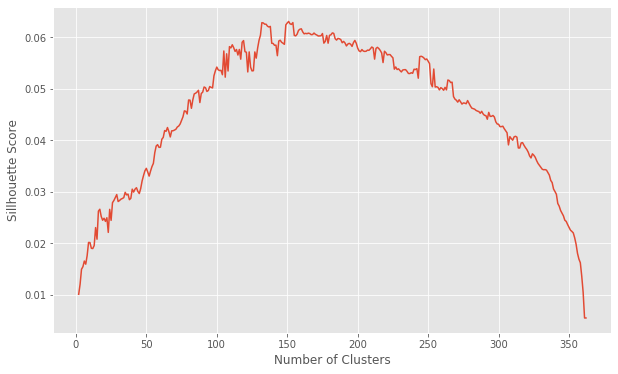

In [412]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(list(silhouette_scores.keys()), 
         list(silhouette_scores.values()))
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Sillhouette Score');

### Considering that this is only looking at 10 artists and 362 songs, the KMeans model is not working well. This may mean the features are not set up well for finding clusters. 

In [406]:
max(silhouette_scores.values())

0.06304029335950068

In [416]:
working_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362 entries, 0 to 6110
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   artist              362 non-null    object
 1   title               362 non-null    object
 2   lyrics              362 non-null    object
 3   lyrics_tokens       362 non-null    object
 4   word_count          362 non-null    int64 
 5   unique_word_count   362 non-null    int64 
 6   token_count         362 non-null    int64 
 7   unique_token_count  362 non-null    int64 
dtypes: int64(4), object(4)
memory usage: 25.5+ KB


In [418]:
working_df['artist'].unique()

array(['Drake', 'Kenny Chesney', 'Keith Urban', 'Jason Aldean',
       'Taylor Swift', 'Rascal Flatts', 'Brad Paisley', 'Tim McGraw',
       'George Strait', 'Toby Keith'], dtype=object)